In [21]:
try:
    import graphlab as gl
    import graphlab.aggregate as agg
    import matplotlib.pyplot as plt
    from matplotlib import rcParams
    import datetime as dt
    %matplotlib inline
    
except:
    raise ImportError("Key libraries cannot be loaded.")

In [22]:
rcParams['figure.figsize'] = (10,10)
rcParams['axes.labelsize'] = 20
rcParams['axes.titlesize'] = 22
rcParams['xtick.labelsize'] = 16
rcParams['xtick.direction'] = 'out'
rcParams['ytick.direction'] = 'out'

def clean_top(ax):
    for x in ax.spines.values():
        x.set_visible(false)
    ax.grid(True, 'major',color ='w', linestyle = '-',linewidth = 1.4)
    ax.path.set_facecolor(0.92)
    ax.set_axisbelow(True)
    ax.xaxis.set_tricks_position('bottom')
    ax.yaxis.set_tricks_position('left')
    


In [23]:
import os

f_userdata = 'user_edges_2011-07-13'

if os.path.exists(f_userdata):
    sf = gl.SFrame(f_userdata)
else:
    url_userdata = 'https://static.turi.com/datasets/bitcoin/{}.txt'.format(f_userdata)
    sf = gl.SFrame.read_csv(url_userdata, delimiter='\t', header=False,
                              column_type_hints={'X1': int, 'X2': int, 'X3': float})
    sf.rename({'X1': 'src', 'X2': 'dst', 'X3': 'btc', 'X4': 'timestamp'})
    sf.save(f_userdata)

In [24]:
# Show graphs and sframes inside ipython notebook
gl.canvas.set_target('ipynb')

sf.show()

In [25]:
sf['timestamp'] = sf['timestamp'].str_to_datetime('%Y-%m-%d-%H-%M-%S')
sf.add_columns(sf['timestamp'].split_datetime(column_name_prefix=None, limit=['year', 'month', 'day']))

src,dst,btc,timestamp,year,month,day
1,5994,8.94,2011-07-04 09:05:56,2011,7,4
905914,20572,0.01,2011-06-23 19:10:01,2011,6,23
905914,622803,220.07592886,2011-06-23 19:10:01,2011,6,23
823336,118969,2.12,2011-05-16 01:58:01,2011,5,16
823336,330686,0.56210609,2011-05-16 01:58:01,2011,5,16
2,282877,0.15,2011-05-23 04:48:17,2011,5,23
2,902253,1.35,2011-05-23 04:48:17,2011,5,23
448634,40297,0.88,2011-06-11 06:00:01,2011,6,11
448634,71810,0.11,2011-06-11 06:00:01,2011,6,11
373684,2909,35.0,2010-10-19 10:37:48,2010,10,19


In [26]:
f_price  = 'https://static.turi.com/datasets/bitcoin/market-price.csv'
sf_price  = gl.SFrame.read_csv(f_price, delimiter= ',', header=False, column_type_hints=[str, float])
sf_price.rename({'X1': 'timestamp' , 'X2': 'close-price'})
sf_price['timestamp'] = sf_price['timestamp'].str_to_datetime('%d/%m/%Y')
sf_price.add_columns(sf_price['timestamp'].split_datetime(column_name_prefix = None, limit = ['year', 'month', 'day']))
sf_price.head(5)

Finished parsing file https://static.turi.com/datasets/bitcoin/market-price.csv

Parsing completed. Parsed 1916 lines in 0.015634 secs.

timestamp,close-price,year,month,day
2009-01-03 00:00:00,0.0,2009,1,3
2009-01-04 00:00:00,0.0,2009,1,4
2009-01-05 00:00:00,0.0,2009,1,5
2009-01-06 00:00:00,0.0,2009,1,6
2009-01-07 00:00:00,0.0,2009,1,7


In [27]:
sf = sf.join(sf_price, on=['year', 'month', 'day'], how='left')
sf.remove_column('timestamp.1')

sf['dollar'] = sf.apply(lambda x: x['btc'] * x['close-price'])
sf['dollar_label'] = sf['dollar'].apply(lambda x: '$' + str(round(x, 2)))

In [28]:
g = gl.SGraph().add_edges(sf, src_field='src', dst_field='dst')


In [29]:
g.summary()

{'num_edges': 1961636L, 'num_vertices': 881678L}

NameError: name 'clean_plot' is not defined

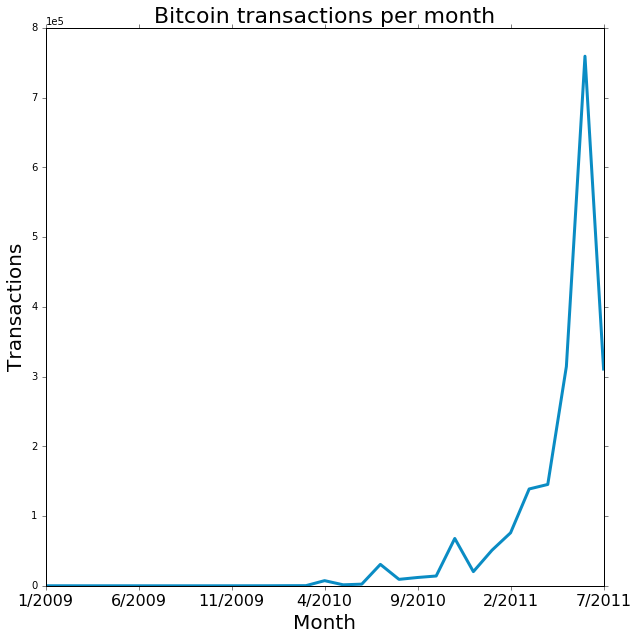

In [30]:
transaction_count = sf.groupby(['year' , 'month'], agg.COUNT).sort(['year', 'month'], ascending=True)
# sort the results by year and month
n_count = transaction_count.num_rows()

# add a column with x-axis plot labels
transaction_count['label'] = transaction_count['month'].astype(str) + "/" + transaction_count['year'].astype(str)

#plotfig, 

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(transaction_count['Count'], lw =3,color = '#0a8cc4')
ax.set_title("Bitcoin transactions per month")
ax.set_ylabel("Transactions")
ax.set_xlabel("Month")

xticks = ax.get_xticks().astype(int)
transaction_count_label = list(transaction_count['label'])
ticklabels = list([transaction_count_label[i] for i in xticks])
ax.set_xticklabels(ticklabels)

ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

clean_plot(ax)
fig.show()



NameError: name 'clean_plot' is not defined

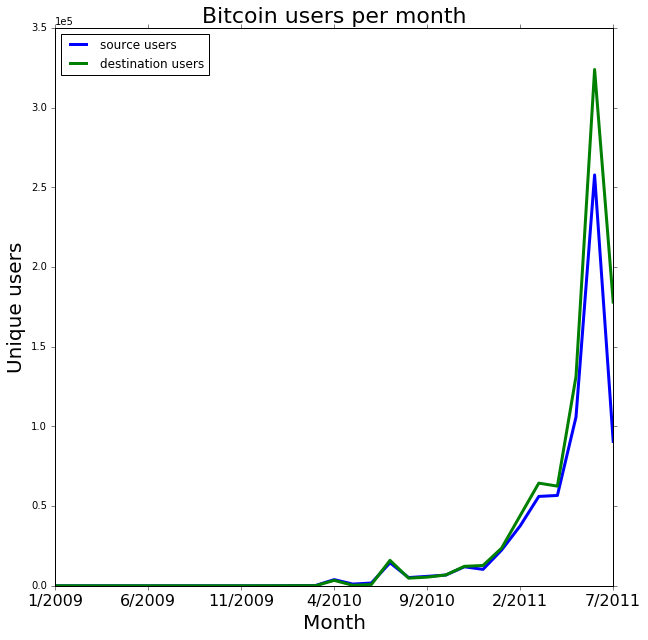

In [31]:
# find the number of unique source users by month
month_source_count = sf.groupby(['year', 'month', 'src'], agg.COUNT).sort(['year', 'month'], ascending=True)
source_count = month_source_count.groupby(['year', 'month'], agg.COUNT).sort(['year', 'month'], ascending=True)

# find the number of unique destination users by month
month_dest_count = sf.groupby(['year', 'month', 'dst'], agg.COUNT).sort(['year', 'month'], ascending=True)
dest_count = month_dest_count.groupby(['year', 'month'], agg.COUNT).sort(['year', 'month'], ascending=True)

# add columns with x-axis plot labels
source_count['label'] = source_count['month'].astype(str) + "/" + source_count['year'].astype(str)

# plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(source_count['Count'], lw=3, label='source users')
ax.plot(dest_count['Count'], lw=3, label='destination users')
ax.set_title("Bitcoin users per month")
ax.set_ylabel("Unique users")
ax.set_xlabel("Month")
ax.legend(loc='upper left')

xticks = ax.get_xticks().astype(int)
source_count_label = list(source_count['label'])
ticklabels = list([source_count_label[i] for i in xticks])
ax.set_xticklabels(ticklabels)

ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

clean_plot(ax)
fig.show()

In [36]:
def count_degree(src, edge, dst):
    dst['in_degree'] += 1
    src['out_degree'] += 1
    return (src, edge, dst)

def get_degree(g):
    new_g = gl.SGraph(g.vertices, g.edges)
    new_g.vertices['in_degree'] = 0
    new_g.vertices['out_degree'] = 0
    return new_g.triple_apply(count_degree, ['in_degree', 'out_degree']).get_vertices()

sf_degree = get_degree(g)
sf_degree['total_degree'] = sf_degree['in_degree'] + sf_degree['out_degree']

NameError: name 'clean_plot' is not defined

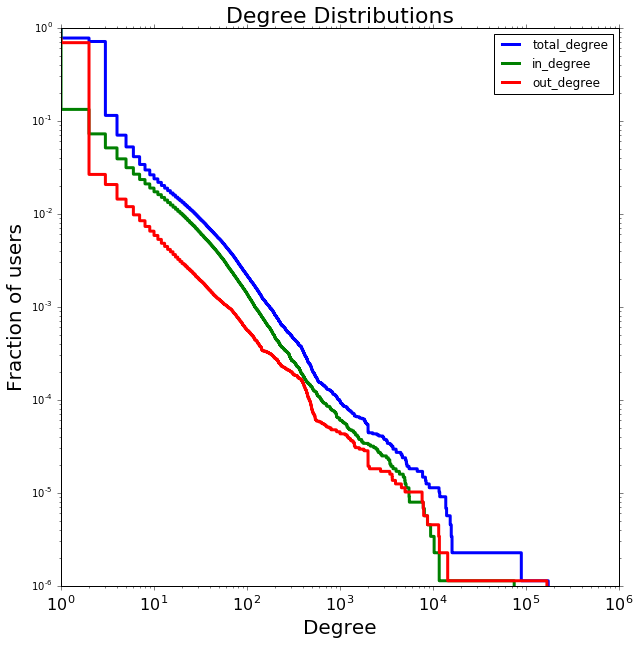

In [45]:
import numpy as np
import  matplotlib
fig, ax = plt.subplots()
for deg_type in ['total_degree', 'in_degree', 'out_degree']:
    counts = np.bincount(list(sf_degree[deg_type]))
    ecdf = np.cumsum(counts) / float(sf_degree.num_rows())
    ax.step(range(len(ecdf)), 1 - ecdf, lw = 3, where= 'post' ,label = deg_type)
    
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Degree")
ax.set_ylabel("Fraction of users")
ax.set_title("Degree Distributions")
clean_plot(ax)
fig.show()

In [46]:
print "In-degree outliers"
print sf_degree.topk('in_degree', k=5)

print "Out-degree outliers"
print sf_degree.topk('out_degree', k=5)

In-degree outliers
+------+-----------+------------+--------------+
| __id | in_degree | out_degree | total_degree |
+------+-----------+------------+--------------+
|  23  |   74628   |   14381    |    89009     |
|  18  |   11657   |    3648    |    15305     |
|  59  |   10278   |    3429    |    13707     |
|  16  |    9422   |    4570    |    13992     |
|  74  |    8715   |    5003    |    13718     |
+------+-----------+------------+--------------+
[5 rows x 4 columns]

Out-degree outliers
+--------+-----------+------------+--------------+
|  __id  | in_degree | out_degree | total_degree |
+--------+-----------+------------+--------------+
|  175   |    5514   |   167767   |    173281    |
|   23   |   74628   |   14381    |    89009     |
| 791028 |    100    |   11708    |    11808     |
| 321039 |     98    |   11507    |    11605     |
|  1995  |    371    |    8736    |     9107     |
+--------+-----------+------------+--------------+
[5 rows x 4 columns]



In [47]:
btc_small = sf[sf['btc']<=5]['btc']
print "Number of small transactions:", len(btc_small)
print "Proportion of all transactions:", float(len(btc_small)) / sf.num_rows()
btc_small.show()

Number of small transactions: 1354923
Proportion of all transactions: 0.690710712895


In [48]:
sf[['src', 'dst', 'btc', 'timestamp', 'dollar']].topk('btc', k=5)

src,dst,btc,timestamp,dollar
56871,16256,432109.876543,2011-06-12 13:57:20,10798425.8148
16256,307659,432077.766543,2011-06-19 19:17:28,8156159.16793
22746,907453,424242.424242,2011-06-23 07:50:15,6787878.78787
34595,380076,400000.0,2011-01-27 00:33:55,166960.0
307659,754833,382077.766543,2011-06-19 23:01:22,7212329.16793


In [49]:
u307659_edges = g.get_edges(src_ids=[307659, None], dst_ids=[None, 307659])
u307659_edges.head()

Columns:
	__src_id	int
	__dst_id	int
	btc	float
	timestamp	datetime
	year	int
	month	int
	day	int
	close-price	float
	dollar	float
	dollar_label	str

Rows: 3

Data:
+----------+----------+---------------+---------------------+------+-------+-----+
| __src_id | __dst_id |      btc      |      timestamp      | year | month | day |
+----------+----------+---------------+---------------------+------+-------+-----+
|  16256   |  307659  | 432077.766543 | 2011-06-19 19:17:28 | 2011 |   6   |  19 |
|  307659  |  643745  |    50000.0    | 2011-06-19 23:01:22 | 2011 |   6   |  19 |
|  307659  |  754833  | 382077.766543 | 2011-06-19 23:01:22 | 2011 |   6   |  19 |
+----------+----------+---------------+---------------------+------+-------+-----+
+-------------+---------------+--------------+
| close-price |     dollar    | dollar_label |
+-------------+---------------+--------------+
|   18.8766   | 8156159.16793 | $8156159.17  |
|   18.8766   |    943830.0   |  $943830.0   |
|   18.8766   | 7212329.16793 | $7212329.17  |
+-------------+---------------+--------------+
[3 rows x 10 columns]

In [51]:
pr = gl.pagerank.create(g,verbose = False)
pr_out = pr.get('pagerank')
pr_out.topk('pagerank', k=5)

__id,pagerank,delta
23,11380.8930204,9.10550351702
18,4124.68311515,3.32566704506
74,2722.93822325,4.15554219738
16,2501.06912144,2.49029993987
59,2302.3725134,3.85763174876


In [56]:
idx_wleaks = 9264
wleaks_net = g.get_neighborhood(ids=idx_wleaks, radius=1, full_subgraph=False)
wleaks_net.show(highlight=[idx_wleaks])

In [57]:
sf_wleaks = wleaks_net.get_edges().sort('timestamp', ascending=True)
sf_wleaks = sf_wleaks.add_row_number()

In [59]:
balance = [0.] * sf_wleaks.num_rows()
balance[0] = sf_wleaks[0]['dollar']

for i in range(1, sf_wleaks.num_rows()):
    if sf_wleaks[i]['__src_id'] == idx_wleaks and sf_wleaks[i]['__dst_id'] != idx_wleaks:
        balance[i] = balance[i - 1] - sf_wleaks[i]['dollar']
        
    elif sf_wleaks[i]['__src_id'] != idx_wleaks and sf_wleaks[i]['__dst_id'] == idx_wleaks:
        balance[i] = balance[i - 1] + sf_wleaks[i]['dollar']

    else:
        balance[i] = balance[i - 1]
        
sf_wleaks['balance'] = balance

NameError: name 'clean_plot' is not defined

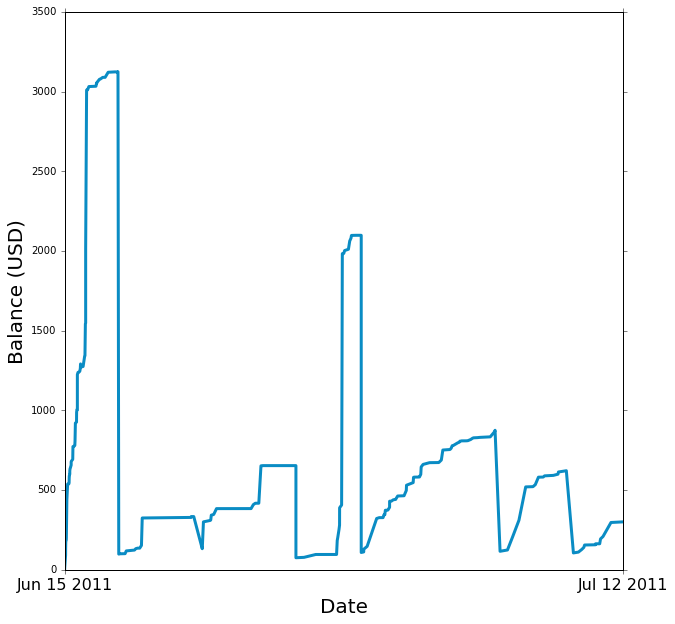

In [60]:
fig, ax = plt.subplots()
ax.plot(sf_wleaks['timestamp'].astype(int), sf_wleaks['balance'], lw=3, color='#0a8cc4')
ax.set_ylabel("Balance (USD)")
ax.set_xlabel("Date")

xlim_dates = gl.SArray([sf_wleaks[0]['timestamp'], sf_wleaks[-1]['timestamp']])
ax.set_xlim(xlim_dates.astype(int))
ax.set_xticks(xlim_dates.astype(int))
ax.set_xticklabels(xlim_dates.datetime_to_str('%b %d %Y'))

clean_plot(ax)
fig.show()

In [61]:
net1 = gl.SGraph().add_edges(wleaks_net.get_edges(src_ids=[idx_wleaks]),
                             src_field='__src_id', dst_field='__dst_id')
net1.show(vlabel='id', highlight=[idx_wleaks], elabel='dollar_label',
          arrows=True, vlabel_hover=False, elabel_hover=False)

In [62]:
targets = net1.get_edges()['__dst_id']
net2 = g.get_neighborhood(ids=targets, radius=0, full_subgraph=True)
net2.show(vlabel='id', highlight=targets)

In [63]:
net2_edges = net2.get_edges()
targets = net2_edges[net2_edges['btc'] > 100]['__dst_id']

In [64]:
net3 = g.get_edges(src_ids=targets)
net3

__src_id,__dst_id,btc,timestamp,year,month,day,close-price,dollar,dollar_label


In [65]:
net3 = g.get_edges(dst_ids=targets)
net3

__src_id,__dst_id,btc,timestamp,year,month,day,close-price,dollar,dollar_label
9264,283026,150.0,2011-06-17 17:19:05,2011,6,17,19.3898,2908.47,$2908.47
9264,384012,115.0,2011-06-29 20:48:42,2011,6,29,17.3,1989.5,$1989.5


In [66]:
idx_thief = 16657
idx_victim = 27783

thief_net = g.get_neighborhood(ids=idx_thief, radius=1, full_subgraph=False)
thief_net.show(vlabel='id', elabel='dollar_label', arrows=True, highlight=[idx_thief, idx_victim])

In [68]:
net = g.get_neighborhood(ids = idx_thief,radius =2, full_subgraph=False)
edges = net.get_edges()
mask = (edges['__src_id'] != 23) * (edges['__dst_id'] != 23)  # get only edges that don't involve 23

thief_net2 = gl.SGraph().add_edges(edges[mask], src_field='__src_id', dst_field='__dst_id')
thief_net2.show(vlabel='id', highlight=[idx_thief, idx_victim], vlabel_hover=True)

In [71]:
net = g.get_neighborhood(ids=idx_victim, radius=2, full_subgraph=False)
vic_edges = net.get_edges()
vic_edges = vic_edges[vic_edges['timestamp'] >= dt.datetime.strptime('2011-06-01', '%Y-%m-%d')]
vic_net2 = gl.SGraph().add_edges(vic_edges, src_field='__src_id', dst_field='__dst_id')

In [72]:
thief_verts = set(thief_net2.get_vertices()['__id'])
vic_verts = set(vic_net2.get_vertices()['__id'])
common_verts = set.intersection(thief_verts, vic_verts)

In [73]:
','.join([str(i) for i in common_verts])

'572864,888325,27783,112654,16657,260244,570264,11294,49827,305965,175,10289,2226,586163,7990,7223,32116,86080,326,892364,37586,515546,348,15586,33763,843876,126181,19441,337652,46868'

In [76]:
theft_edge = g.get_edges(src_ids=idx_victim, dst_ids=idx_thief)
theft_time = theft_edge.topk('timestamp', k=1)['timestamp'][0]
print "Theft occurred at: ", theft_time, '\n'
theft_edge.head()

Theft occurred at:  2011-06-13 17:52:23 



__src_id,__dst_id,btc,timestamp,year,month,day,close-price,dollar,dollar_label
27783,16657,1.0,2011-06-13 17:34:04,2011,6,13,24.5,24.5,$24.5
27783,16657,25000.0,2011-06-13 17:52:23,2011,6,13,24.5,612500.0,$612500.0


In [79]:
def follow_the_money(g, vertex, attribute, threshold, radius=1):
    if radius == 0:
        return

    else:
        # find all outgoing edges from vertex
        edges = g.get_edges(src_ids=vertex)

        if len(edges) == 0:
            return

        else:
            edges = edges[edges[attribute] > threshold]  #only keep 'later' edges
            out_edges = edges[edges.column_names()]

            # recurse
            for row in edges:
                new_edges = follow_the_money(g, vertex=row['__dst_id'],
                                            attribute=attribute,
                                            threshold=row[attribute],
                                            radius=radius - 1)
                if new_edges is not None:
                    out_edges = out_edges.append(new_edges)

            out_edges = out_edges.groupby(out_edges.column_names(), {})
            return out_edges

In [80]:
tainted_edges = follow_the_money(g, idx_thief, attribute='timestamp',
                                 threshold=theft_time, radius=1)
net = gl.SGraph().add_edges(tainted_edges, src_field='__src_id', dst_field='__dst_id')
net.show(vlabel='id', elabel='dollar_label', arrows=True, highlight=[idx_thief])

In [81]:
launder_edge = g.get_edges(src_ids=112654, dst_ids=185593)
launder_time = launder_edge.topk('timestamp', k=1)['timestamp'][0]

edges = follow_the_money(g, vertex=185593, attribute='timestamp',
                         threshold=launder_time, radius=2)
edges['label'] = edges['timestamp'].datetime_to_str('%Y-%m-%d-%H-%M-%S')

In [82]:
net = gl.SGraph().add_edges(edges, src_field='__src_id', dst_field='__dst_id')
net.show(vlabel='id', elabel='label', arrows=True, highlight=[idx_thief, 185593])